In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory

In [103]:
from scipy import stats
from scipy.stats import uniform
import statsmodels.api as sm


# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold

In [104]:
data = pd.read_csv('../raw_data/dataset.csv',sep=';')
data = data.copy()
data.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [105]:
data.shape

(99976, 43)

## 1. feature selection

In [106]:
# Missing data percentage
round((data.isnull().sum()/len(data)).sort_values(ascending=False),2)

worst_status_active_inv                0.70
account_worst_status_12_24m            0.67
account_worst_status_6_12m             0.60
account_incoming_debt_vs_paid_0_24m    0.59
account_worst_status_3_6m              0.58
account_status                         0.54
account_worst_status_0_3m              0.54
avg_payment_span_0_3m                  0.49
avg_payment_span_0_12m                 0.24
num_active_div_by_paid_inv_0_12m       0.23
num_arch_written_off_12_24m            0.18
num_arch_written_off_0_12m             0.18
account_days_in_rem_12_24m             0.12
account_days_in_term_12_24m            0.12
account_days_in_dc_12_24m              0.12
default                                0.10
sum_paid_inv_0_12m                     0.00
sum_capital_paid_account_12_24m        0.00
sum_capital_paid_account_0_12m         0.00
recovery_debt                          0.00
status_max_archived_0_24_months        0.00
status_max_archived_0_6_months         0.00
status_3rd_last_archived_0_24m  

In [107]:
# # removing column "uuid" from the dataset
# data_id = data['uuid']
# data.drop(['uuid'], axis=1, inplace=True)
# # setting target and removing the "default" from dataset
# target = data['default']
# data.drop(['default'], axis=1, inplace=True)
# # isna and isnull were not recognizing "nan" 
# data = data.replace('nan', np.NaN)
###
# removing the missing values of the target and these raws from the dataset
###
# removing coulumn "uuid" from the dataset
# data_id = data['uuid']
# #_ = data.reset_index()
# #data = _.drop(['uuid'], axis=1)
# data.drop(['uuid'], axis=1, inplace=True)
# # setting target and removing the "default" from dataset
# target = data['default'].dropna()
# data.dropna(subset=['default'], axis=0, inplace=True)
# data.drop(['default'], axis=1, inplace=True)
# # isna and isnull were not recognizing "nan" 
# data = data.replace('nan', np.NaN)


In [108]:
 # converting these columns to "object" type
list_float_to_obj = ["worst_status_active_inv", "account_status","account_worst_status_0_3m",
                     "account_worst_status_12_24m", "account_worst_status_3_6m", "account_worst_status_6_12m",
                     "status_last_archived_0_24m", "status_2nd_last_archived_0_24m","status_3rd_last_archived_0_24m",
                     "status_max_archived_0_6_months","status_max_archived_0_12_months","status_max_archived_0_24_months",
                     "has_paid"]

_ = [data.__setitem__(feature, data[feature].astype("object")) for feature in list_float_to_obj]

As one can see we do have features with a high numbers of unique values


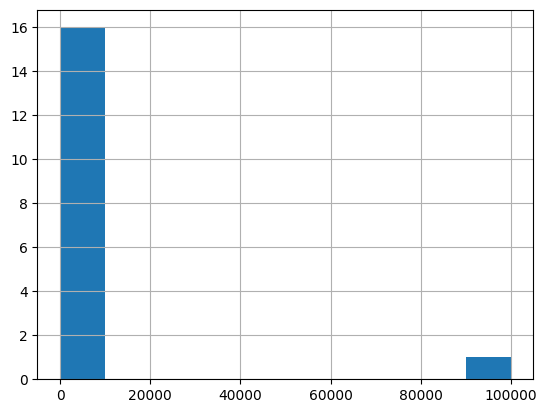

In [109]:
# The above code have got the following  warning message: 
    # UserWarning: Persisting input arguments took 2.21s to run.
    # If this happens often in your code, it can cause performance problems 
    # (results will be correct in all cases). 
    # The reason for this is probably some large input arguments for a wrapped
    #  function (e.g. large strings).
    # THIS IS A JOBLIB ISSUE.
# To tackle this issue we're foreseeing the possibility of removing from the dataset all categoric features with 7 unique values or more.
feat_categorical_nunique = data.select_dtypes(include='object').nunique()
feat_categorical_nunique.hist();
print("As one can see we do have features with a high numbers of unique values")
# categorical features 
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique > 7].index)

In [110]:
feat_categorical_small
# data['merchant_category'].unique()
# len(data['merchant_group'].unique())
# I am considering to remove
    ## 1. "merchant_category"
    ## 2. "name_in_email"
    # I will check on this on next model by looking at feature_importance_ attribute

['uuid', 'merchant_category', 'merchant_group', 'name_in_email']

#### 1st first apporach

In [111]:
# removing coulumn "uuid" from the dataset
data_id = data['uuid']
#_ = data.reset_index()
#data = _.drop(['uuid'], axis=1)
data.drop(['uuid'], axis=1, inplace=True)
# setting target and removing the "default" from dataset
#target = data['default'].dropna()
data.dropna(subset=['default'], axis=0, inplace=True)
#data.drop(['default'], axis=1, inplace=True)
# isna and isnull were not recognizing "nan" 
data = data.replace('nan', np.NaN)

In [112]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

feature_ohe = OneHotEncoder(sparse_output=False) # Instantiate One hot encoder
encoded_features = feature_ohe.fit_transform(data[['name_in_email', 'merchant_group', 'merchant_category']])

# Create a dataframe with the encoded features
column_names = feature_ohe.get_feature_names_out()
encoded_df = pd.DataFrame(encoded_features, columns=column_names)

# Concatenate the original dataframe with the encoded dataframe
data = pd.concat([data, encoded_df], axis=1)

# Drop the original columns
data.drop(columns=['name_in_email', 'merchant_group', 'merchant_category'], inplace=True)

data.head()

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,...,merchant_category_Sex toys,merchant_category_Sports gear & Outdoor,merchant_category_Tobacco,merchant_category_Tools & Home improvement,merchant_category_Travel services,merchant_category_Underwear,merchant_category_Video Games & Related accessories,merchant_category_Wheels & Tires,"merchant_category_Wine, Beer & Liquor",merchant_category_Youthful Shoes & Clothing
0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
# defeining data_GLM with the target default
data_GLM = pd.DataFrame()
data_GLM['default'] = data['default']
data_GLM[column_names] = data[column_names]
data_GLM

,default,name_in_email_F,name_in_email_F+L,name_in_email_F1+L,name_in_email_Initials,name_in_email_L,name_in_email_L1+F,name_in_email_Nick,name_in_email_no_match,merchant_group_Automotive Products,...,merchant_category_Sex toys,merchant_category_Sports gear & Outdoor,merchant_category_Tobacco,merchant_category_Tools & Home improvement,merchant_category_Travel services,merchant_category_Underwear,merchant_category_Video Games & Related accessories,merchant_category_Wheels & Tires,"merchant_category_Wine, Beer & Liquor",merchant_category_Youthful Shoes & Clothing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89973,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
89974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
data_GLM.iloc[:,1:]

,name_in_email_F,name_in_email_F+L,name_in_email_F1+L,name_in_email_Initials,name_in_email_L,name_in_email_L1+F,name_in_email_Nick,name_in_email_no_match,merchant_group_Automotive Products,merchant_group_Children Products,...,merchant_category_Sex toys,merchant_category_Sports gear & Outdoor,merchant_category_Tobacco,merchant_category_Tools & Home improvement,merchant_category_Travel services,merchant_category_Underwear,merchant_category_Video Games & Related accessories,merchant_category_Wheels & Tires,"merchant_category_Wine, Beer & Liquor",merchant_category_Youthful Shoes & Clothing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89972,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89973,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
89974,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
new_col = list(range(1, len(column_names)+1))
data_GLM = data_GLM.rename(columns=dict(zip(data_GLM.iloc[:,1:].columns, new_col)))
data_GLM

,default,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89973,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
89974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
number_to_word = {
    1: "one", 2: "two", 3: "three", 4: "four", 5: "five", 6: "six",
    7: "seven", 8: "eight", 9: "nine", 10: "ten", 11: "eleven", 12: "twelve",
    13: "thirteen", 14: "fourteen", 15: "fifteen", 16: "sixteen", 17: "seventeen",
    18: "eighteen", 19: "nineteen", 20: "twenty", 30: "thirty", 40: "forty",
    50: "fifty", 60: "sixty", 70: "seventy", 80: "eighty", 90: "ninety"
}

new_col_words = [number_to_word[i] for i in new_col]


KeyError: 21

In [119]:
# for the seek of simplicity we're looking at subgroup of the datset
# H_0: there's a correlation
# We've chosen Binomial for its binary outcome
# It looks none of the features under analyses are significant to explain our default variable
# So we reject the null hypothesis. 

formula = "default ~ " + " + ".join("I({})".format(i) for i in range(1, 79))



model = sm.GLM.from_formula(formula, data=data_GLM, family=sm.families.Binomial())
results = model.fit()

# Print summary of results
[results.summary()]

PatsyError: Number of rows mismatch between data argument and I(1) (89976 versus 1)
    default ~ I(1) + I(2) + I(3) + I(4) + I(5) + I(6) + I(7) + I(8) + I(9) + I(10) + I(11) + I(12) + I(13) + I(14) + I(15) + I(16) + I(17) + I(18) + I(19) + I(20) + I(21) + I(22) + I(23) + I(24) + I(25) + I(26) + I(27) + I(28) + I(29) + I(30) + I(31) + I(32) + I(33) + I(34) + I(35) + I(36) + I(37) + I(38) + I(39) + I(40) + I(41) + I(42) + I(43) + I(44) + I(45) + I(46) + I(47) + I(48) + I(49) + I(50) + I(51) + I(52) + I(53) + I(54) + I(55) + I(56) + I(57) + I(58) + I(59) + I(60) + I(61) + I(62) + I(63) + I(64) + I(65) + I(66) + I(67) + I(68) + I(69) + I(70) + I(71) + I(72) + I(73) + I(74) + I(75) + I(76) + I(77) + I(78)
              ^^^^

In [120]:
formula = "default ~ " + " + ".join("I({})".format(i) for i in range(1, 79))

model = sm.GLM.from_formula(formula, data=data_GLM, family=sm.families.Binomial())
results = model.fit()

# Print summary of results
[results.summary()]


PatsyError: Number of rows mismatch between data argument and I(1) (89976 versus 1)
    default ~ I(1) + I(2) + I(3) + I(4) + I(5) + I(6) + I(7) + I(8) + I(9) + I(10) + I(11) + I(12) + I(13) + I(14) + I(15) + I(16) + I(17) + I(18) + I(19) + I(20) + I(21) + I(22) + I(23) + I(24) + I(25) + I(26) + I(27) + I(28) + I(29) + I(30) + I(31) + I(32) + I(33) + I(34) + I(35) + I(36) + I(37) + I(38) + I(39) + I(40) + I(41) + I(42) + I(43) + I(44) + I(45) + I(46) + I(47) + I(48) + I(49) + I(50) + I(51) + I(52) + I(53) + I(54) + I(55) + I(56) + I(57) + I(58) + I(59) + I(60) + I(61) + I(62) + I(63) + I(64) + I(65) + I(66) + I(67) + I(68) + I(69) + I(70) + I(71) + I(72) + I(73) + I(74) + I(75) + I(76) + I(77) + I(78)
              ^^^^

In [ ]:
# Lets continue our analysis
# Get summary table and convert to pandas DataFrame
summary_table = summary_col([results], stars=True, float_format='%.2f', model_names=['Model 1'])
summary_df = pd.DataFrame(summary_table.tables[0]).reset_index()

# Set multirow to False and print summary table
summary_df['multirow'] = False
print(summary_col([results], stars=True, float_format='%.2f', model_names=['Model 1'], multirow=False))